In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import glob
import tqdm
import time
import yaml
import h5py
import scipy
import torch
import pickle
import joblib
import random
import sklearn
import logging
import datetime
import torch.fft
import torchvision
import torchvision.models as models

import numpy as np
import pandas as pd
import xarray as xr
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from collections import defaultdict
from scipy.signal import convolve2d
from torch.optim.lr_scheduler import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple

from scipy.sparse import csr_matrix
from colour import Color

import multiprocessing as mp
#mp.set_start_method('spawn')

from functools import partial

from hagelslag.evaluation.ProbabilityMetrics import *
from hagelslag.evaluation.MetricPlotter import *

In [2]:
%matplotlib inline

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [8]:
with open("models/resnet18_double_duplicate/holo_data.yml") as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [9]:
n_bins = conf["data"]["n_bins"]
tile_size = conf["data"]["tile_size"]
step_size = conf["data"]["step_size"]
marker_size = conf["data"]["marker_size"]
synthetic_path = conf["data"]["data_path"]

epochs = conf["trainer"]["epochs"]
train_batch_size = conf["trainer"]["train_batch_size"]
valid_batch_size = conf["trainer"]["valid_batch_size"]
batches_per_epoch = conf["trainer"]["batches_per_epoch"]
stopping_patience = conf["trainer"]["stopping_patience"]
model_loc = conf["trainer"]["output_path"]

fcl_layers = conf["resnet"]["fcl_layers"]
dropout = conf["resnet"]["dropout"]
output_size = conf["resnet"]["output_size"]
resnet_model = conf["resnet"]["resnet_model"]
pretrained = conf["resnet"]["pretrained"]

learning_rate = conf["optimizer"]["learning_rate"]
weight_decay = conf["optimizer"]["weight_decay"]

# n_bins = 1000  # number of bins in histogram
# tile_size = 512  # size of tiled images in pixels
# step_size = 128  # amount that we shift the tile to make a new tile
# marker_size = 10 # UNET gaussian marker width (standard deviation) in um

valid_batch_size = 32

There are 11174402 total model parameters


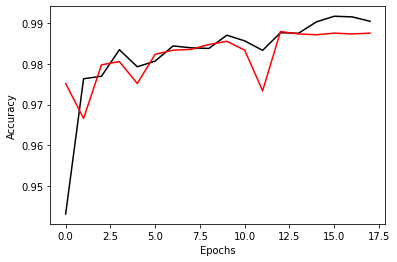

In [10]:
# Load a model
f = pd.read_csv(f"{model_loc}/training_log.csv")
plt.plot(f["epoch"], f["train_accuracy"], c = 'k')
plt.plot(f["epoch"], f["valid_accuracy"], c = 'r')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# fcl_layers = []
# dropout = 0.2
# output_size = 2
# resnet_model = 18
# pretrained = True

model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = pretrained).to(device)


checkpoint = torch.load(
    f"{model_loc}/best.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"There are {total_params} total model parameters")

In [11]:
#model.share_memory()

prop = InferencePropagator(
    synthetic_path, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    model = model,
    device = device
)

In [12]:
h_idx = 10
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)

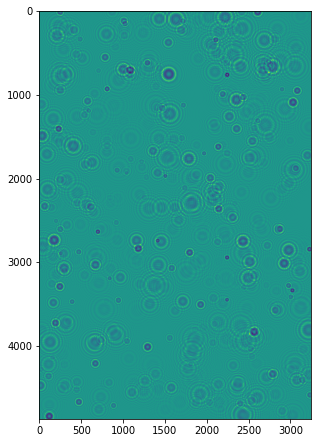

In [13]:
shape = test_image.values.shape
ratio = shape[0] / shape[1]

plt.figure(figsize = (5, 5 * ratio))
plt.imshow(test_image.values)

### Create a list of z-values to propagate to

In [14]:
z_list = prop.create_z_plane_lst(planes_per_call=1)

### Set up thresholds to use for computing ROC

In [15]:
obs_threshold = 1.0
thresholds = 1.0 - np.logspace(-5, 0, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
thresholds = thresholds[::-1]

### Initialize the generator

In [16]:
inference_generator = prop.get_next_z_planes_labeled(
    h_idx, 
    z_list, 
    batch_size = valid_batch_size, 
    thresholds = thresholds,
    obs_threshold = obs_threshold
)

### Main loop to call the generator, predict with the model, and aggregate and save the results

##### Make the data directory inside the model_loc path if it does not exist

In [22]:
try:
    os.mkdir(f"{model_loc}/data")
except FileExistsError:
    pass

Plane: 0 at z: 0.014072 plane_acc: 0.946860 holo_acc: 0.946860 holo_csi: 1.000000:   0%|          | 1/1000 [00:05<1:28:37,  5.32s/it]

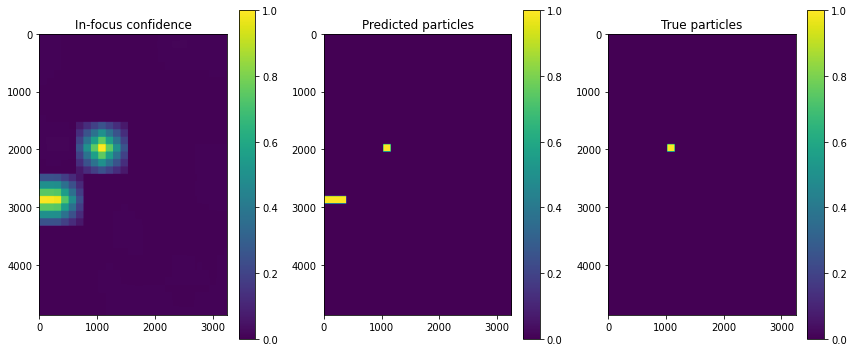

Plane: 1 at z: 0.014216 plane_acc: 0.946860 holo_acc: 0.946860 holo_csi: 1.000000:   0%|          | 3/1000 [00:11<1:04:53,  3.91s/it]

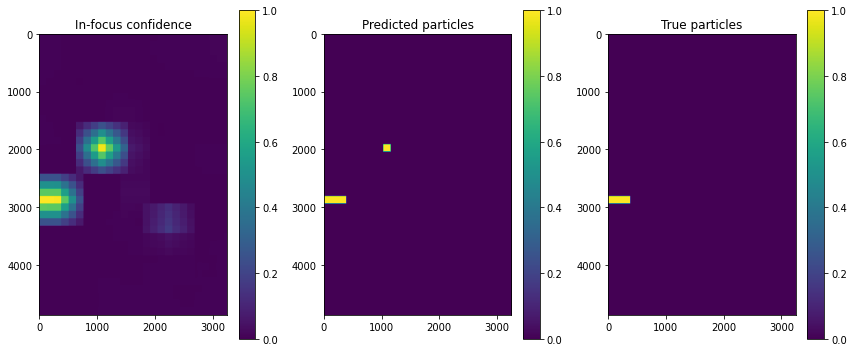

Plane: 2 at z: 0.01436 plane_acc: 0.939614 holo_acc: 0.944444 holo_csi: 1.000000:   0%|          | 4/1000 [00:18<1:21:11,  4.89s/it] 

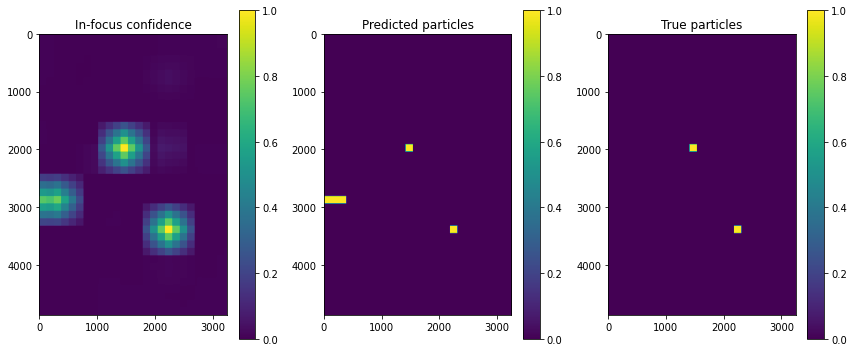

Plane: 3 at z: 0.014504 plane_acc: 0.961353 holo_acc: 0.948671 holo_csi: 1.000000:   1%|          | 6/1000 [00:24<1:07:16,  4.06s/it]

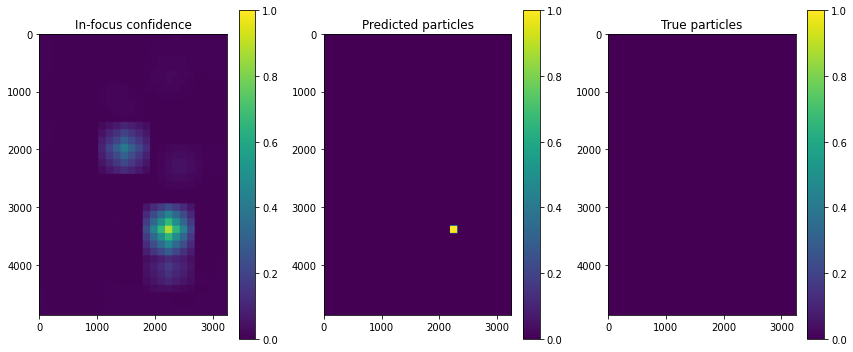

Plane: 3 at z: 0.014504 plane_acc: 0.961353 holo_acc: 0.948671 holo_csi: 1.000000:   0%|          | 4/1000 [00:29<2:01:20,  7.31s/it]


KeyboardInterrupt: 

In [17]:
plot = True
save_arrays = True

model.eval()
with torch.no_grad():

    jiter = tqdm.tqdm(
        enumerate(inference_generator), 
        total = len(z_list), 
        leave=True
    )

    total_accuracy = []
    roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
    
    for z_idx, results_dict in jiter:

        # Get stuff from the results dictionary
        pred_label = results_dict["pred_label"]
        pred_prob = results_dict["pred_proba"]
        true_label = results_dict["true_label"]
        acc = results_dict["acc"]
        z_plane = int(results_dict["z_plane"])

        if save_arrays:
            # Save the giant matrices as sparse arrays, as most elements are zero
            save_sparse_csr(f"{model_loc}/data/prob_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_prob))

            pred_label = pred_label == 1.0
            save_sparse_csr(f"{model_loc}/data/pred_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(pred_label))

            true_label = true_label == 1.0
            save_sparse_csr(f"{model_loc}/data/true_{h_idx}_{z_plane}.npz", scipy.sparse.csr_matrix(true_label))

        # Update any metrics you want printed to screen
        total_accuracy.append(acc)
        roc.merge(results_dict["roc"])
        
        to_print = f"Plane: {z_idx} at z: {z_plane*1e-6} plane_acc: {acc:.6f} holo_acc: {np.mean(total_accuracy):.6f}"
        to_print += f" holo_csi: {roc.max_csi():.6f}"
        jiter.set_description(to_print)
        jiter.update()

        # Option to plot each result per plane
        if plot:
            fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
            p1 = ax0.imshow(pred_prob, vmin = 0,  vmax = 1)
            ax0.set_title("In-focus confidence")
            fig.colorbar(p1, ax=ax0)

            p2 = ax1.imshow(pred_label, vmin = 0,  vmax = 1)
            ax1.set_title("Predicted particles")
            fig.colorbar(p2, ax=ax1)

            p3 = ax2.imshow(true_label, vmin = 0, vmax = 1)
            ax2.set_title("True particles")
            fig.colorbar(p3, ax=ax2)

            plt.tight_layout()
            plt.show()

In [ ]:
rocs = sorted(glob.glob(f"{model_loc}/data/roc_{h_idx}_*.pkl"), 
                  key = lambda x: int(x.strip(".pkl").split("_")[-1]))

In [32]:
for k, roc_fn in enumerate(rocs):
    with open(roc_fn, "rb") as fid:
        if k == 0:
            roc = joblib.load(fid)
        else:
            roc.merge(joblib.load(fid))

with open(f"{model_loc}/roc_{h_idx}.pkl", "wb") as fid:
    joblib.dump(roc, fid)

roc_curve([roc], ["Resnet-18"], ["orange"], ["o"], f"{model_loc}/roc_comparison_{h_idx}.png")
performance_diagram([roc], ["Resnet-18"], ["orange"], ["o"], f"{model_loc}/performance_comparison_{h_idx}.png")

In [20]:
roc.max_csi()

1.0

### Load the data from saved location

In [25]:
# for z_idx in range(50):

#     pred_prob = load_sparse_csr(f"images/prob_{z_idx}")
#     pred_label = load_sparse_csr(f"images/pred_{z_idx}")
#     true_label = load_sparse_csr(f"images/true_{z_idx}")

#     fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))
#     p1 = ax0.imshow(pred_prob.toarray(), vmin = 0,  vmax = 1)
#     ax0.set_title("In-focus confidence")
#     fig.colorbar(p1, ax=ax0)

#     _pred_label = pred_label == 1.0
#     p2 = ax1.imshow(_pred_label.toarray(), vmin = 0,  vmax = 1)
#     ax1.set_title("Predicted particles")
#     fig.colorbar(p2, ax=ax1)

#     _true_label = true_label == 1.0
#     p3 = ax2.imshow(_true_label.toarray(), vmin = 0, vmax = 1)
#     ax2.set_title("True particles")
#     fig.colorbar(p3, ax=ax2)

#     plt.tight_layout()
#     plt.show()

In [16]:
z_file_indices = sorted([int(x.replace(".npz", "").split("_")[-1]) for x in glob.glob(f"{model_loc}/data/true_*")])

In [18]:
red = Color("red")
red_white = list(map(str, red.range_to(Color("white"), 100)))[::-1]
color_range = np.array([x / 100 for x in list(range(100))])

In [19]:
def read_one_plane(z_idx):
    
    colors = []
    x, y, z = [], [], []
    xt, yt, zt = [], [], []

    # Load from sparse 
    pred_prob = load_sparse_csr(f"{model_loc}/data/prob_{h_idx}_{z_idx}")
    pred_label = load_sparse_csr(f"{model_loc}/data/pred_{h_idx}_{z_idx}")
    true_label = load_sparse_csr(f"{model_loc}/data/true_{h_idx}_{z_idx}")
    
    # Convert
    _pred_prob = pred_prob.toarray()
    _pred_label = (pred_label == 1.0).toarray()
    _true_label = (true_label == 1.0).toarray()
    
    # Compute some metrics
    #dice_score = dice_coef(_pred_label, _true_label)
    #dice_score_1 = dice(_pred_label, _true_label, k = 0.0)
    # TP, FP, TN, FN = sklearn.metrics.classification_report()
    
    condition1 = np.where(_pred_label)
    condition2 = np.where(_true_label)
    
    if len(condition1[0]) > 0:
        x += list(condition1[0])
        y += list(condition1[1])
        z += [z_idx for g in range(len(condition1[0]))]
        colors += [red_white[np.abs(color_range - _pred_prob[r][c]).argmin()] for r,c in zip(*condition1)]

    if len(condition2[0]) > 0:
        xt += list(condition2[0])
        yt += list(condition2[1])
        zt += [z_idx for g in range(len(condition2[0]))] 
        
    results = {
        "preds": [x, y, z, colors],
        "truths": [xt, yt, zt],
        "metrics": []
    }
        
    return results

In [ ]:
colors = []
X, Y, Z = [], [], []
Xt, Yt, Zt = [], [], []

max_planes = 1000

ncpus = 8

with mp.Pool(ncpus) as p:
    
    for results in tqdm.tqdm(p.imap(read_one_plane, z_file_indices[:max_planes]), total = max_planes):

        X += results["preds"][0]
        Y += results["preds"][1]
        Z += results["preds"][2]
        colors += results["preds"][3]

        Xt += results["truths"][0]
        Yt += results["truths"][1]
        Zt += results["truths"][2]

In [ ]:
fig = plt.figure(figsize = (10, 14))
ax = plt.axes(projection ="3d")

max_z_view = 100
max_z = z_file_indices[max_z_view-1]
maxn = len([zz for zz in Z if zz <= max_z])

ax.scatter3D(X[:maxn], Y[:maxn], Z[:maxn], c = 'r', alpha = 0.005, zorder = 1, marker = 'o') 
ax.scatter3D(Xt[:maxn], Yt[:maxn], Zt[:maxn], c = 'b', alpha = 0.005, zorder = 1, marker = 's')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim([0, 4872])
ax.set_ylim([0, 3248])
ax.set_zlim([z_file_indices[0], z_file_indices[max_planes-1]])

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize = (12, 5))

hist, binx, biny = np.histogram2d(X, Y, bins = (test_image.shape[0] // step_size, test_image.shape[1] // step_size))
#x = np.linspace(min(X), max(X), hist.shape[0])
#y = np.linspace(min(Y), max(Y), hist.shape[1])
#x, y = np.meshgrid(x, y)
#ax0.contour(x, y, hist, zdir='z', offset=-3.)
ax0.imshow(hist, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_xlabel("x")
ax0.set_ylabel("y")

histxz, binx, binz = np.histogram2d(X, Z, bins = (test_image.shape[0] // step_size, 1000))
#x = np.linspace(min(X), max(X), hist.shape[0])
#z = np.linspace(min(Z), max(Z), hist.shape[1])
#x, z = np.meshgrid(x, z)
ax1.imshow(histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax1.set_xlabel("z")
ax1.set_ylabel("x")

histyz, biny, binz = np.histogram2d(Y, Z, bins = (test_image.shape[1] // step_size, 1000))
#y = np.linspace(min(Y), max(Y), hist.shape[1])
#z = np.linspace(min(Z), max(Z), hist.shape[1])
#z, y = np.meshgrid(z, y)
ax2.imshow(histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax2.set_xlabel("z")
ax2.set_ylabel("y")

plt.tight_layout()

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (15, 10))

histxz, binx, binz = np.histogram2d(X, Z, bins = (test_image.shape[0] // step_size, 1000))
pred_histxz = np.where(histxz > 0.0, 1.0, 0.0)
ax0.imshow(pred_histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_ylabel("x", fontsize = 12)
ax0.set_title("Predicted particles", fontsize = 12)

histxz, binx, binz = np.histogram2d(Xt, Zt, bins = (test_image.shape[0] // step_size, 1000))
true_histxz = np.where(histxz > 0.0, 1.0, 0.0)
ax1.imshow(true_histxz, origin = "lower", aspect='auto', cmap='gist_gray')
ax1.set_xlabel("z", fontsize = 12)
ax1.set_ylabel("x", fontsize = 12)
ax1.set_title("Real particles", fontsize = 12)

plt.tight_layout()

In [ ]:
accuracy = (pred_histxz == true_histxz).mean()
print(accuracy)

In [ ]:
sklearn.metrics.multilabel_confusion_matrix(true_histxz, pred_histxz).sum(0)

In [ ]:
#dice_coef2(true_histxz, pred_histxz)

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (15, 10))

histyz, biny, binz = np.histogram2d(Y, Z, bins = (test_image.shape[1] // step_size, 1000))
pred_histyz = np.where(histyz > 0.0, 1.0, 0.0) # make everything black and white
ax0.imshow(pred_histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax0.set_xlabel("z", fontsize = 12)
ax0.set_ylabel("y", fontsize = 12)
ax0.set_title("Predicted particles", fontsize = 12)

histyz, biny, binz = np.histogram2d(Yt, Zt, bins = (test_image.shape[1] // step_size, 1000))
true_histyz = np.where(histyz > 0.0, 1.0, 0.0)
ax1.imshow(true_histyz, origin = "lower", aspect='auto', cmap='gist_gray')
ax1.set_xlabel("z", fontsize = 12)
ax1.set_ylabel("y", fontsize = 12)
ax1.set_title("Real particles", fontsize = 12)

plt.tight_layout()

### Make a similar plot but on the smaller grid

In [66]:
sx = test_image.shape[0] // step_size
sy = test_image.shape[1] // step_size

In [69]:
def process_one_plane(z_idx):
    
    x, y, z = [], [], []
    xt, yt, zt = [], [], []
    
    true_arr = np.zeros((sx, sy))
    pred_arr = np.zeros((sx, sy))
    
    pred_prob = load_sparse_csr(f"{model_loc}/data/prob_{h_idx}_{z_idx}")
    pred_label = load_sparse_csr(f"{model_loc}/data/pred_{h_idx}_{z_idx}")
    true_label = load_sparse_csr(f"{model_loc}/data/true_{h_idx}_{z_idx}")
    
    for ((row_idx, col_idx), (row_slice, col_slice)) in prop.idx2slice.items():
        
        max_label = np.amax(pred_label[row_slice, col_slice])
        max_probs = np.amax(pred_prob[row_slice, col_slice])
        max_truth = np.amax(true_label[row_slice, col_slice])

        true_arr[row_idx, col_idx] = max_truth
        pred_arr[row_idx, col_idx] = max_label

        if max_label == 1.0:
            x.append(row_idx)
            y.append(col_idx)
            z.append(z_idx)

        if max_truth == 1.0:
            xt.append(row_idx)
            yt.append(col_idx)
            zt.append(z_idx)
        
    results = {
        "preds": [x, y, z],
        "truths": [xt, yt, zt],
        "metrics": []
    }
    
    return results

In [71]:
x, y, z = [], [], []
xt, yt, zt = [], [], []

max_planes = 1000

ncpus = 8
with mp.Pool(ncpus) as p:
    
    for results in tqdm.tqdm(p.imap(process_one_plane, z_file_indices[:max_planes]), total = max_planes):
        
        x += results["preds"][0]
        y += results["preds"][1]
        z += results["preds"][2]

        xt += results["truths"][0]
        yt += results["truths"][1]
        zt += results["truths"][2]

In [ ]:
fig = plt.figure(figsize = (10, 20))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, c = "r", alpha = 0.1, zorder = 1, marker = 'o') 
ax.scatter3D(xt, yt, zt, c = 'b', alpha = 1.0, zorder = 2, marker = 'o')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim([0, sx])
ax.set_ylim([0, sy])
ax.set_zlim([z_file_indices[0], z_file_indices[max_planes-1]])

### How to visualize results better?